<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/Phone_LSTM_Les_trans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import os


BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/UCI HAR Dataset'

def load_file(filepath):
    df = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return df.values

def load_group(filenames, prefix=''):
    loaded = []
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    return np.dstack(loaded)   # (samples, timesteps, features)

def load_dataset_group(group, prefix=''):
    filepath = prefix + '/' + group + '/Inertial Signals/'
    filenames = []
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt',  'body_acc_y_'+group+'.txt',  'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = load_group(filenames, filepath)
    y = load_file(prefix + '/' + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=BASE_PATH):
    trainX, trainy = load_dataset_group('train', prefix)
    testX,  testy  = load_dataset_group('test',  prefix)
    # 라벨 1~6 → 0~5
    trainy = trainy - 1
    testy  = testy - 1
    trainy_oh = to_categorical(trainy)
    testy_oh  = to_categorical(testy)
    print('trainX:', trainX.shape, 'trainy:', trainy.shape)
    print('testX:',  testX.shape,  'testy:',  testy.shape)
    return trainX, trainy, trainy_oh, testX, testy, testy_oh

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset(BASE_PATH)

/tmp/ipython-input-3649546441.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3649546441.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3649546441.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3649546441.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-36495

trainX: (7352, 128, 9) trainy: (7352, 1)
testX: (2947, 128, 9) testy: (2947, 1)


/tmp/ipython-input-3649546441.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3649546441.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [ ]:
def extend_sequence(X, y, step=128, window=256):

    X_new, y_new = [], []
    for i in range(0, X.shape[1] - window + 1, step):
        X_new.append(X[:, i:i+window, :])
        y_new.append(y)
    return np.concatenate(X_new, axis=0), np.concatenate(y_new, axis=0)


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 3D -> 2D로 펼치기
N_train, T, F = trainX.shape        # 예: (7352, 128, 9)
N_test = testX.shape[0]

trainX_2d = trainX.reshape(-1, F)   # (7352*128, 9)
testX_2d  = testX.reshape(-1, F)

# train으로만 fit
scaler = StandardScaler()
scaler.fit(trainX_2d)

# 다시 변환하고 3D로 되돌리기
trainX_scaled = scaler.transform(trainX_2d).reshape(N_train, T, F)
testX_scaled  = scaler.transform(testX_2d).reshape(N_test, T, F)


In [ ]:
# trainX_scaled
energy = np.mean(np.abs(trainX_scaled), axis=(1,2))
threshold = np.percentile(energy, 98)  # 상위 2% 정도 제거
mask = energy < threshold
trainX_clean = trainX_scaled[mask]
trainy_clean = trainy_one_hot[mask]


In [ ]:
# train → train/val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    trainX, trainy_one_hot,
    test_size=0.2,
    random_state=100,
    stratify=trainy_one_hot
)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(5881, 128, 9) (1471, 128, 9) (5881, 6) (1471, 6)


In [ ]:
y_train_label = np.argmax(y_train, axis=1)
idx_3 = np.where(y_train_label == 3)[0]
idx_4 = np.where(y_train_label == 4)[0]

repeat_factor = 2   # 3,4 데이터 2배 복제
X_train_extra = np.concatenate([
    X_train[idx_3].repeat(repeat_factor, axis=0),
    X_train[idx_4].repeat(repeat_factor, axis=0)
], axis=0)

y_train_extra = np.concatenate([
    y_train[idx_3].repeat(repeat_factor, axis=0),
    y_train[idx_4].repeat(repeat_factor, axis=0)
], axis=0)

# 원래 train과 합치기
X_train = np.concatenate([X_train, X_train_extra], axis=0)
y_train = np.concatenate([y_train, y_train_extra], axis=0)

print("balanced:", X_train.shape, y_train.shape)

balanced: (10137, 128, 9) (10137, 6)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

y_train_label = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_label),
    y=y_train_label
)
class_weights = {i: w for i, w in enumerate(class_weights)}
print(class_weights)


{0: np.float64(1.7222222222222223), 1: np.float64(1.969114219114219), 2: np.float64(2.141318124207858), 3: np.float64(0.5472951085195983), 4: np.float64(0.5124355474673946), 5: np.float64(1.5017777777777779)}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

n_timesteps = X_train.shape[1]   # 128
n_features  = X_train.shape[2]   # 9
n_outputs   = y_train.shape[1]   # 6

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
class_weights[3] *= 1.8   # sitting
class_weights[4] *= 1.8   # standing
print(class_weights)


history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[rlr, es],
    class_weight=class_weights,
    verbose=1
)


{0: np.float64(1.7222222222222223), 1: np.float64(1.969114219114219), 2: np.float64(2.141318124207858), 3: np.float64(0.9851311953352769), 4: np.float64(0.9223839854413103), 5: np.float64(1.5017777777777779)}
Epoch 1/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5688 - loss: 1.5613 - val_accuracy: 0.6547 - val_loss: 0.7452 - learning_rate: 0.0010
Epoch 2/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7682 - loss: 0.7705 - val_accuracy: 0.8668 - val_loss: 0.3973 - learning_rate: 0.0010
Epoch 3/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8797 - loss: 0.4060 - val_accuracy: 0.9347 - val_loss: 0.1888 - learning_rate: 0.0010
Epoch 4/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8921 - loss: 0.2853 - val_accuracy: 0.9368 - val_loss: 0.1729 - learning_rate: 0.0010
Epoch 5/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9056 - loss: 0.2467 - val_accuracy: 0.9497 - val_loss: 0.1316 - learning_rate: 0.0010
Epoch 6/50
159/159 ━━━━━━━

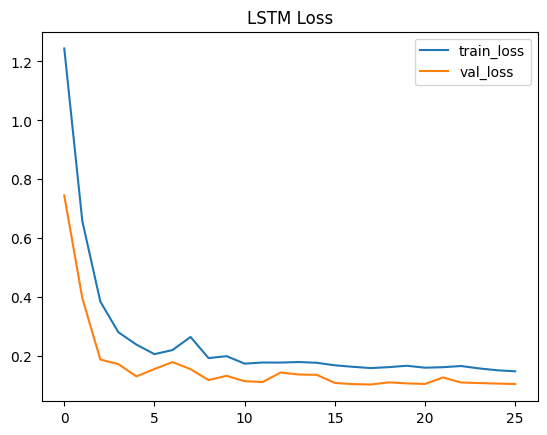

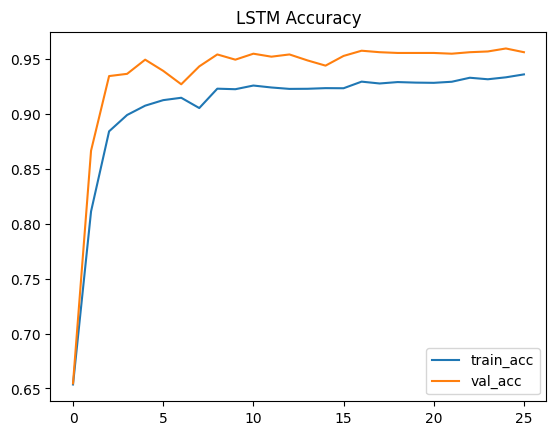

In [ ]:
# 학습 곡선
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('LSTM Loss')
plt.show()

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('LSTM Accuracy')
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test acc: 0.9097387173396675
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       496
           1       0.88      0.99      0.93       471
           2       0.96      0.99      0.98       420
           3       0.81      0.81      0.81       491
           4       0.83      0.82      0.82       532
           5       0.99      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



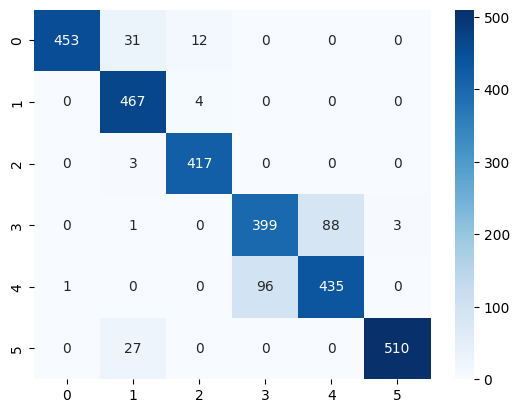

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_prob = model.predict(testX)   # 이미 스케일된 testX
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = testy.ravel()

print("Test acc:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()


In [ ]:
# =========================
# 1D ResNet, Transformer, ResNet+Transformer
# =========================
from tensorflow.keras import layers, models
import tensorflow as tf

def resnet_block(x, filters, kernel_size=3):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters, 1, padding='same')(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def make_resnet_1d(n_timesteps, n_features, n_outputs):
    inputs = layers.Input(shape=(n_timesteps, n_features))
    x = layers.Conv1D(64, 7, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = layers.MaxPooling1D(2)(x)

    x = resnet_block(x, 128)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(n_outputs, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def transformer_encoder(x, num_heads, key_dim, ff_dim, dropout=0.1):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn = layers.Dropout(dropout)(attn)
    x = layers.LayerNormalization(epsilon=1e-6)(x + attn)

    ffn = layers.Dense(ff_dim, activation='relu')(x)
    ffn = layers.Dense(x.shape[-1])(ffn)
    ffn = layers.Dropout(dropout)(ffn)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ffn)
    return x

def make_transformer_1d(n_timesteps, n_features, n_outputs):
    inputs = layers.Input(shape=(n_timesteps, n_features))

    # 간단한 위치 임베딩
    positions = tf.range(start=0, limit=n_timesteps, delta=1)
    pos_embed = layers.Embedding(input_dim=n_timesteps, output_dim=n_features)(positions)
    pos_embed = tf.expand_dims(pos_embed, 0)
    x = inputs + pos_embed  # (B, T, F)

    x = transformer_encoder(x, num_heads=4, key_dim=n_features, ff_dim=128)
    x = transformer_encoder(x, num_heads=4, key_dim=n_features, ff_dim=128)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(n_outputs, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def make_resnet_transformer(n_timesteps, n_features, n_outputs):
    inputs = layers.Input(shape=(n_timesteps, n_features))
    # CNN으로 먼저 줄이기
    x = layers.Conv1D(64, 7, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    # 길이 T/2에 맞춰 위치 임베딩
    seq_len = x.shape[1]
    positions = tf.range(start=0, limit=seq_len, delta=1)
    pos_embed = layers.Embedding(input_dim=seq_len, output_dim=64)(positions)
    pos_embed = tf.expand_dims(pos_embed, 0)
    x = x + pos_embed

    x = transformer_encoder(x, num_heads=4, key_dim=64, ff_dim=128)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(n_outputs, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def run_kfold_with_model(make_model_fn, X_all, y_all_oh, y_all_label, skf,
                         epochs=20, batch_size=64, model_name="model"):
    fold = 1
    acc_list = []
    print(f"\n===== {model_name} K-FOLD START =====")
    for train_idx, val_idx in skf.split(X_all, y_all_label):
        X_tr, X_val = X_all[train_idx], X_all[val_idx]
        y_tr, y_val = y_all_oh[train_idx], y_all_oh[val_idx]

        model = make_model_fn(X_all.shape[1], X_all.shape[2], y_all_oh.shape[1])

        model.fit(
            X_tr, y_tr,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            verbose=0
        )

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val, axis=1)

        acc = accuracy_score(y_true, y_pred)
        acc_list.append(acc)
        print(f"[{model_name}] fold {fold} acc:", acc)
        print(classification_report(y_true, y_pred))
        fold += 1

    print(f"===== {model_name} mean acc: {np.mean(acc_list):.4f} =====")


In [ ]:
# ResNet만
run_kfold_with_model(make_resnet_1d,
                     X_all, y_all_oh, y_all_label, skf,
                     epochs=20, batch_size=64,
                     model_name="ResNet-1D")

# Transformer만
run_kfold_with_model(make_transformer_1d,
                     X_all, y_all_oh, y_all_label, skf,
                     epochs=20, batch_size=64,
                     model_name="Transformer-1D")

# ResNet + Transformer
run_kfold_with_model(make_resnet_transformer,
                     X_all, y_all_oh, y_all_label, skf,
                     epochs=20, batch_size=64,
                     model_name="ResNet+Transformer")



===== ResNet-1D K-FOLD START =====
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
[ResNet-1D] fold 1 acc: 0.9723300970873786
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       344
           1       0.99      1.00      1.00       309
           2       1.00      1.00      1.00       281
           3       0.94      0.90      0.92       355
           4       0.91      0.95      0.93       382
           5       1.00      1.00      1.00       389

    accuracy                           0.97      2060
   macro avg       0.97      0.97      0.97      2060
weighted avg       0.97      0.97      0.97      2060

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[ResNet-1D] fold 2 acc: 0.9626213592233009
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       0.99      1.00      1.00       309
           2       1.00      1.00      1.00       281
           3       0.90      0.88     

In [ ]:
# train / test 합치기
X_all = np.concatenate([trainX, testX], axis=0)
y_all = np.concatenate([trainy, testy], axis=0)              # (N, 1)
y_all_oh = np.concatenate([trainy_one_hot, testy_one_hot], axis=0)

# stratified k-fold는 1차원 라벨이 필요
y_all_label = y_all.ravel()

print(X_all.shape, y_all_label.shape)


(10299, 128, 9) (10299,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def make_simple_lstm(n_timesteps, n_features, n_outputs):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

n_timesteps = X_all.shape[1]
n_features  = X_all.shape[2]
n_outputs   = y_all_oh.shape[1]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
acc_list = []

for train_idx, val_idx in skf.split(X_all, y_all_label):
    print(f"===== FOLD {fold} =====")

    X_tr, X_val = X_all[train_idx], X_all[val_idx]
    y_tr, y_val = y_all_oh[train_idx], y_all_oh[val_idx]

    # 모델 새로 만들기
    model = make_simple_lstm(n_timesteps, n_features, n_outputs)



    history = model.fit(
        X_tr, y_tr,
        epochs=30,
        batch_size=64,
        validation_data=(X_val, y_val),
        verbose=0
    )

    # fold 평가
    y_val_pred_prob = model.predict(X_val)
    y_val_pred = np.argmax(y_val_pred_prob, axis=1)
    y_val_true = np.argmax(y_val, axis=1)

    acc = accuracy_score(y_val_true, y_val_pred)
    acc_list.append(acc)
    print("fold acc:", acc)
    print(classification_report(y_val_true, y_val_pred))

    fold += 1

print("==== mean acc:", np.mean(acc_list))


===== FOLD 1 =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
fold acc: 0.9529126213592233
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       1.00      1.00      1.00       309
           2       1.00      1.00      1.00       281
           3       0.83      0.92      0.87       355
           4       0.92      0.82      0.87       382
           5       1.00      1.00      1.00       389

    accuracy                           0.95      2060
   macro avg       0.96      0.96      0.96      2060
weighted avg       0.95      0.95      0.95      2060

===== FOLD 2 =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
fold acc: 0.9538834951456311
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       344
           1       0.99      1.00      0.99       309
           2       1.00      0.99      0.99       281
           3       0.86      0.90      0.88       356
           4       0.90      0.86      0.88       381
           5       1.00      1.00      1.00       389

    accuracy                           0.95      2060
   macro avg       0.96      0.96      0.96      2060
weighted avg       0.95      0.95      0.95      2060

===== FOLD 3 =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
fold acc: 0.9475728155339805
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       345
           1       0.97      1.00      0.98       309
           2       1.00      0.96      0.98       281
           3       0.85      0.90      0.87       356
           4       0.90      0.85      0.87       381
           5       1.00      1.00      1.00       388

    accuracy                           0.95      2060
   macro avg       0.95      0.95      0.95      2060
weighted avg       0.95      0.95      0.95      2060

===== FOLD 4 =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
fold acc: 0.945631067961165
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       345
           1       1.00      1.00      1.00       309
           2       1.00      1.00      1.00       281
           3       0.81      0.91      0.85       355
           4       0.90      0.80      0.85       381
           5       1.00      1.00      1.00       389

    accuracy                           0.95      2060
   macro avg       0.95      0.95      0.95      2060
weighted avg       0.95      0.95      0.95      2060

===== FOLD 5 =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
fold acc: 0.9514327343370568
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       1.00      1.00      1.00       308
           2       1.00      1.00      1.00       282
           3       0.83      0.91      0.87       355
           4       0.90      0.82      0.86       381
           5       1.00      1.00      1.00       389

    accuracy                           0.95      2059
   macro avg       0.96      0.96      0.95      2059
weighted avg       0.95      0.95      0.95      2059

==== mean acc: 0.9502865468674113
